In [1]:
import numpy as np
import pandas as pd
import sklearn

import os
import re
from sklearn.utils import shuffle
import matplotlib.pyplot as plt

C:\Anaconda3\lib\site-packages\sklearn\utils\fixes.py:313: FutureWarning: numpy not_equal will not check object identity in the future. The comparison did not return the same result as suggested by the identity (`is`)) and will change.
  _nan_object_mask = _nan_object_array != _nan_object_array


## Load the data

In [11]:
dir_ = os.path.join("data", "arXivMeta_example")
#dir_ = os.path.join("data", "arXivMeta_sample")

file_list = []
for file in os.listdir(dir_):
    file_path = os.path.join(dir_, file)
    file_list.append(file_path)
    print(f"using {file}")
    
all_data = pd.concat([pd.read_csv(file, delimiter='\t', na_values='nan') for file in file_list])

using arXivMeta_all_from_2010-01-01_to_2010-07-01.csv
using arXivMeta_all_from_2010-07-02_to_2010-12-31.csv
using arXivMeta_all_from_2011-01-01_to_2011-07-01.csv
using arXivMeta_all_from_2011-07-02_to_2011-12-31.csv
using arXivMeta_all_from_2012-01-01_to_2012-07-01.csv
using arXivMeta_all_from_2012-07-02_to_2012-12-31.csv


## Handle NaNs

In [12]:
# count the NaNs
all_data.isnull().sum()

id            10
authors        0
title         10
abstract      10
categories    10
dtype: int64

In [13]:
# show the NaNs
rows_with_nulls = all_data.isnull().any(axis=1)
print("No. of rows with NaNs: ", sum(rows_with_nulls))
all_data[rows_with_nulls][:3]

No. of rows with NaNs:  10


,id,authors,title,abstract,categories
22299,NaN,[],NaN,NaN,NaN
22300,NaN,[],NaN,NaN,NaN
23584,NaN,[],NaN,NaN,NaN


In [14]:
# All the NaNs are aligned in empty rows.
# We can just drop them.
all_data = all_data.dropna(axis=0, how='any', inplace=False)

## Remove records that start with *This paper has been withdrawn*

In [15]:
withdrawn = all_data.abstract.str.contains("^\s+This paper has been withdrawn")
print(sum(withdrawn))
all_data = all_data[~withdrawn]

248


## Remove suspiciously short abstracts
There are articles where the abstract serves as a comment rather than a summary, e.g. "Discussion on SOME_REFERENCE."

In [16]:
example = all_data[all_data.id == '1001.2975'].abstract.values[0].strip()
print(example)
len(example)

Comment on "Harold Jeffreys's Theory of Probability Revisited"
[arXiv:0804.3173]


80

Let's just decide that abstracts shorter than 100 characters are noice rather than information and remove them.

In [17]:
tresh = 100
print("Removing", sum(all_data.abstract.str.len() < tresh), f"records with abstracts shorter than {tresh}")
all_data = all_data.loc[all_data.abstract.str.len() > tresh]

Removing 675 records with abstracts shorter than 100


## Check for repeated entries

In [18]:
# Count remaining duplicates in each column separately

print("No. repeated entries in column:")
for column in all_data:
    print( f"{column:<11}", len(all_data) - len(all_data[column].unique()) )

No. repeated entries in column:
id          0
authors     38419
title       198
abstract    149
categories  164040


In [19]:
# As a sidenote, recall how does the *duplicated* function in pandas actually work.
# It flags the duplicates starting from the second repeated entry.

df = pd.DataFrame({'a': [1,1,1], 'b': [2,2,3], 'c': [4,5,6]})
print(df.duplicated(subset=['a','b']))

# To get all repeats use the *keep=False* argument
print(df.duplicated(subset=['a','b'], keep=False))

0    False
1     True
2    False
dtype: bool
0     True
1     True
2    False
dtype: bool


In [20]:
# Back to our data.
# There are entries with duplicated abstracts and matching categories.
# The fact that they may have differing titles and authors is fishy but
# it's probably due to typo in the title or added authors

subset=['abstract', 'categories']
duplicates_1 = all_data[all_data.duplicated(subset=subset, keep=False)]
display(pd.concat(g for _, g in duplicates_1.groupby(subset) ))

# This data represents unambiguous mapping from abstracts to categories
# so we want to retain one entry from each bunch of duplicates

print(f"Something wrong with ids, authors or titles above. Keep one of each unique abstract.")
all_data = all_data.drop_duplicates(subset=subset)

,id,authors,title,abstract,categories
10250,1108.4675,"['David Eppstein', 'Michael T. Goodrich', 'Maa...",Category-Based Routing in Social Networks: Mem...,A classic experiment by Milgram shows that i...,cs.SI cs.DS physics.soc-ph
24917,1110.4499,"['David Eppstein', 'Michael T. Goodrich', 'Maa...",Category-Based Routing in Social Networks: Mem...,A classic experiment by Milgram shows that i...,cs.SI cs.DS physics.soc-ph
10699,1102.3009,['Aleksey Kharevsky'],Non - Randomness Stock Market Price Model,A new model for the stock market price analy...,q-fin.GN
23539,1104.2308,['Aleksey Kharevsky'],Non - Randomness Stock Market Price Model (Ame...,A new model for the stock market price analy...,q-fin.GN
10295,1003.4187,"['Chris Armbruster', 'Laurent Romary']",Comparing Repository Types - Challenges and ba...,"After two decades of repository development,...",cs.DL
14085,1005.0839,"['Chris Armbruster', 'Laurent Romary']",Comparing Repository Types - Challenges and ba...,"After two decades of repository development,...",cs.DL
11655,1109.2417,"['Sali Emruli', 'Miroslav Baca']",Internet and political communication - Macedon...,Analysis how to use Internet influence to th...,cs.SI
11656,1109.2418,"['Sali Emruli', 'Tahir Zejneli', 'Florin Agai']",Facebook and political communication -- Macedo...,Analysis how to use Internet influence to th...,cs.SI
3681,1006.1182,"['K. M. Azharul Hasan', 'Mohammad Sabbir Hasan']",A Parsing Scheme for Finding the Design Patter...,Because of the importance of object oriented...,cs.SE
6350,1008.1671,"['K. M. Azharul Hasan', 'Mohammad Sabbir Hasan']",A Parsing Scheme for Finding the Design Patter...,Because of the importance of object oriented...,cs.SE


Something wrong with ids, authors or titles above. Keep one of each unique abstract.


In [21]:
# Now, remaining duplicated abstracts must have differing categories at this point.
# Thus, those records are ambigous for our purposes, and we may want to drop them all.
# Alas, the differing categories are probably 'close'. So, not to throw away reasonably informative data
# but to still keep unambiguous abstract->categories map, we'll again keep one of the duplicates
# One may add *keep=False* to drop_duplicates below, in order to remove them all.

subset=['abstract']
duplicates_2 = all_data[all_data.duplicated(subset=subset, keep=False)]
display(pd.concat(g for _, g in duplicates_2.groupby(subset) ))

print(f"Ambiguous categories. Keep one of each unique abstract.")
all_data = all_data.drop_duplicates(subset=subset)
# all_data = all_data.drop_duplicates(subset=subset, keep=False)

,id,authors,title,abstract,categories
5202,1008.1530,"['Hugo Reinhardt', 'Markus Leder', 'Jan M. Paw...",Hamiltonian Flow of Yang-Mills Theory in Coulo...,A new functional renormalization group equat...,hep-lat hep-th
20642,1011.3462,"['Hugo Reinhardt', 'Markus Leder', 'Jan M. Paw...",Hamiltonian Dyson-Schwinger and FRG Flow Equat...,A new functional renormalization group equat...,hep-th
12848,1203.6214,"['Heru Susanto', 'Mohammad Nabil Almunawar', '...",Integrated Solution Modeling Software: A New P...,Actually Information security becomes a very...,cs.CR
19622,1204.0240,"['Heru Susanto', 'Mohammad Nabil Almunawar', '...",Integrated Solution Modeling Software: A New P...,Actually Information security becomes a very...,cs.CR cs.SE
14,0704.2411,['A. A. Lopatin'],Indecomposable invariants of quivers for dimen...,An upper bound on degrees of elements of a m...,math.RA math.CO
14327,1004.4578,['A. A. Lopatin'],Indecomposable invariants of quivers for dimen...,An upper bound on degrees of elements of a m...,math.CO math.AG math.RA math.RT
23377,1210.1039,"['Julien Ponge', 'Frédéric Le Mouël']",JooFlux: Hijacking Java 7 InvokeDynamic To Sup...,Changing functional and non-functional softw...,cs.OS cs.PL
28934,1211.7345,"['Julien Ponge', 'Frédéric Le Mouël']",JooFlux : modification de code \`a chaud et in...,Changing functional and non-functional softw...,cs.SE
10177,1003.3909,"['G. F. Ali Ahammed', 'Reshma Banu']",Anakyzing the performance of Active Queue Mana...,Congestion is an important issue which resea...,cs.NI
3387,1005.1992,"['G. F. Ali Ahammed', 'Reshma Banu']",Analyzing the Performance of Active Queue Mana...,Congestion is an important issue which resea...,cs.PF


Ambiguous categories. Keep one of each unique abstract.


In [22]:
# At this point there are no duplicated abstracts.
# The duplicated titles could be examined and perhaps removed as well
# but we will not bother to do that

print("No. all records:", len(all_data))
print("No. repeated entries in column:")
for column in all_data:
    print( f"{column:<11}", len(all_data) - len(all_data[column].unique()) )

No. all records: 177810
No. repeated entries in column:
id          0
authors     38335
title       137
abstract    0
categories  163895


---

## Extract the first category as the primary category (*prim_cat*) of each article

In [23]:
# Extract first word from the list of categories in all_data data-frame.
# Take only the term up to a dot from that word

# Although it is not visibly indicated in the dataset,
# these first categories are the primary_categories of each article.
# We make a new column for them.

primary_categories = all_data.categories.str.split().str[0]
all_data['primary_cat'] = primary_categories
all_data[6:9]

,id,authors,title,abstract,categories,primary_cat
6,0704.0492,"['Shenghui Su', 'Shuwang Lu']",Refuting the Pseudo Attack on the REESSE1+ Cry...,We illustrate through example 1 and 2 that t...,cs.CR,cs.CR
7,0704.0642,"['B. Z. Kopeliovich', 'A. H. Rezaeian', 'H. J....",Direct photons and dileptons via color dipoles,Drell-Yan dilepton pair production and inclu...,hep-ph nucl-th,hep-ph
8,0704.0817,"['Hugh Thomas', 'Alexander Yong']",An S_3-symmetric Littlewood-Richardson rule,The classical Littlewood-Richardson coeffici...,math.CO math.RT,math.CO


---

## Map all the categories into top-level topics (*physics*, *mathematics*, etc.)

### Start with creating a mapping

In [24]:
# Read in categories described in the *arXiv_metadata_harvester.ipynb*

from my_utilities import read_dict

physics_genres = read_dict("physics_genres.txt")
print(physics_genres) # That's just what arXiv's API told us

top_cats = read_dict("top_cats.txt")
top_cats # We want those as labels for our categories

{'astro-ph': 'Astrophysics', 'cond-mat': 'Condensed Matter', 'gr-qc': 'General Relativity and Quantum Cosmology', 'hep-ex': 'High Energy Physics - Experiment', 'hep-lat': 'High Energy Physics - Lattice', 'hep-ph': 'High Energy Physics - Phenomenology', 'hep-th': 'High Energy Physics - Theory', 'math-ph': 'Mathematical Physics', 'nlin': 'Nonlinear Sciences', 'nucl-ex': 'Nuclear Experiment', 'nucl-th': 'Nuclear Theory', 'physics': 'Physics (Other)', 'quant-ph': 'Quantum Physics'}


{'cs': 'Computer Science',
 'math': 'Mathematics',
 'physics': 'Physics',
 'q-bio': 'Quantitative Biology',
 'q-fin': 'Quantitative Finance',
 'stat': 'Statistics'}

In [25]:
# Let's have a look at all possible categories

categories_set = set()
for cats in all_data.categories.str.split():
    categories_set.update(set(cats))

categories = pd.Series(list(categories_set))

print(f"We have {len(categories)} unique category labels so far:")
categories_set

We have 164 unique category labels so far:


{'acc-phys',
 'adap-org',
 'alg-geom',
 'astro-ph',
 'astro-ph.CO',
 'astro-ph.EP',
 'astro-ph.GA',
 'astro-ph.HE',
 'astro-ph.IM',
 'astro-ph.SR',
 'atom-ph',
 'bayes-an',
 'chao-dyn',
 'chem-ph',
 'cmp-lg',
 'comp-gas',
 'cond-mat',
 'cond-mat.dis-nn',
 'cond-mat.mes-hall',
 'cond-mat.mtrl-sci',
 'cond-mat.other',
 'cond-mat.quant-gas',
 'cond-mat.soft',
 'cond-mat.stat-mech',
 'cond-mat.str-el',
 'cond-mat.supr-con',
 'cs.AI',
 'cs.AR',
 'cs.CC',
 'cs.CE',
 'cs.CG',
 'cs.CL',
 'cs.CR',
 'cs.CV',
 'cs.CY',
 'cs.DB',
 'cs.DC',
 'cs.DL',
 'cs.DM',
 'cs.DS',
 'cs.ET',
 'cs.FL',
 'cs.GL',
 'cs.GR',
 'cs.GT',
 'cs.HC',
 'cs.IR',
 'cs.IT',
 'cs.LG',
 'cs.LO',
 'cs.MA',
 'cs.MM',
 'cs.MS',
 'cs.NA',
 'cs.NE',
 'cs.NI',
 'cs.OH',
 'cs.OS',
 'cs.PF',
 'cs.PL',
 'cs.RO',
 'cs.SC',
 'cs.SD',
 'cs.SE',
 'cs.SI',
 'cs.SY',
 'dg-ga',
 'funct-an',
 'gr-qc',
 'hep-ex',
 'hep-lat',
 'hep-ph',
 'hep-th',
 'math-ph',
 'math.AC',
 'math.AG',
 'math.AP',
 'math.AT',
 'math.CA',
 'math.CO',
 'math.CT',
 '

In [34]:
# Extract the first level categorization, i.e. up to dot or end of string,
# e.g. cond-mat.quant-gas -> cond-mat, cs.AI -> cs

strip_pattern = re.compile(r'([\w\-]+)')

def strip_to_semitop(cat, pattern=strip_pattern):
    return strip_pattern.match(cat).group(1)

semitop_categories = categories.map(strip_to_semitop)
semitop_categories_set = set(semitop_categories)    

semitop_categories

0          math
1            cs
2            cs
3       physics
4         q-bio
5       physics
6            cs
7            cs
8       physics
9      solv-int
10     chao-dyn
11     cond-mat
12     alg-geom
13         stat
14      physics
15           cs
16           cs
17         math
18      nucl-th
19     cond-mat
20         math
21        q-fin
22      physics
23         math
24        q-fin
25         math
26         math
27      nucl-ex
28        q-fin
29         nlin
         ...   
134          cs
135          cs
136        math
137     physics
138          cs
139          cs
140    funct-an
141    adap-org
142       q-fin
143        math
144       q-bio
145       q-bio
146        math
147          cs
148       q-fin
149          cs
150        math
151       q-bio
152    cond-mat
153    cond-mat
154     physics
155    astro-ph
156          cs
157    astro-ph
158        math
159     physics
160     atom-ph
161          cs
162        math
163        nlin
Length: 164, dtype: obje

In [40]:
# Try to create map from semitop_categories to top_cats using physic_genres

to_top = {}

for top_cat in top_cats:
    to_top[top_cat] = top_cat
    
for genre in physics_genres:
    # writes over mapping[physics]=physics
    to_top[genre] = "phys"
    
to_top

{'cs': 'cs',
 'math': 'math',
 'physics': 'phys',
 'q-bio': 'q-bio',
 'q-fin': 'q-fin',
 'stat': 'stat',
 'astro-ph': 'phys',
 'cond-mat': 'phys',
 'gr-qc': 'phys',
 'hep-ex': 'phys',
 'hep-lat': 'phys',
 'hep-ph': 'phys',
 'hep-th': 'phys',
 'math-ph': 'phys',
 'nlin': 'phys',
 'nucl-ex': 'phys',
 'nucl-th': 'phys',
 'quant-ph': 'phys'}

In [41]:
# let's see which semitop_categories will not be mapped by the 'mapping' dict

semitop_categories[pd.isnull(semitop_categories.map(to_top))]

9      solv-int
10     chao-dyn
12     alg-geom
44        q-alg
75     acc-phys
83     bayes-an
93     patt-sol
94        dg-ga
96      mtrl-th
98     supr-con
106    comp-gas
112      cmp-lg
128     chem-ph
140    funct-an
141    adap-org
160     atom-ph
dtype: object

In [42]:
# We just google those, see how arXiv displays them on its frontend, and assign them by hand below

clean_up_mask = {}
clean_up_mask['acc-phys'] = 'physics'
clean_up_mask['adap-org'] = 'nlin'
clean_up_mask['alg-geom'] = 'math'
clean_up_mask['atom-ph'] = 'physics'
clean_up_mask['chao-dyn'] = 'nlin'
clean_up_mask['comp-gas'] = 'nlin'
clean_up_mask['dg-ga'] = 'math'
clean_up_mask['funct-an'] = 'math'
clean_up_mask['q-alg'] = 'math'
clean_up_mask['solv-int'] = 'nlin'
clean_up_mask['patt-sol'] = 'nlin'
clean_up_mask['bayes-an'] = 'physics'
clean_up_mask['supr-con'] = 'cond-mat'
clean_up_mask['chem-ph'] = 'physics'
clean_up_mask['mtrl-th'] = 'cond-mat'
clean_up_mask['cmp-lg'] = 'cs'
clean_up_mask['comp-gas'] = 'nlin'
#clean_up_mask['solv-int'] = 'nlin'


def clean_up(cat):
    if cat in clean_up_mask:
        return clean_up_mask[cat]
    else:
        return cat


print("Uknown categories:\n", semitop_categories[pd.isnull( semitop_categories.map(clean_up).map(mapping) )] )
print("No. unknown categories:", sum( pd.isnull( semitop_categories.map(clean_up).map(mapping) ) ) )

Uknown categories:
 Series([], dtype: object)
No. unknown categories: 0


### Apply the map

In [45]:
# Ok, assuming there are no uknown categories above,
# we can apply the *strip_to_semitop*, *clean_up* and *to_top* maps to our original categories in the data-frame.
# Pack those three into a vectorized function

def lift_category(cat):
    return to_top[clean_up(strip_to_semitop(cat))]

lift_category = np.vectorize(lift_category)

In [66]:
# # For example

# nico = pd.DataFrame({'a':['cs.AI chao-dyn hep-th']})
# display(nico)

# nico.a = nico.a.str.split().map(lift_category).map(np.unique)
# nico

In [50]:
all_data['top_level_cats'] = all_data.categories.str.split().map(lift_category).map(np.unique)
all_data['primary_top_level_cat'] = all_data.primary_cat.map(lift_category)

In [51]:
all_data[6:9]

,id,authors,title,abstract,categories,primary_cat,top_level_cats,primary_top_level_cat
6,0704.0492,"['Shenghui Su', 'Shuwang Lu']",Refuting the Pseudo Attack on the REESSE1+ Cry...,We illustrate through example 1 and 2 that t...,cs.CR,cs.CR,[cs],cs
7,0704.0642,"['B. Z. Kopeliovich', 'A. H. Rezaeian', 'H. J....",Direct photons and dileptons via color dipoles,Drell-Yan dilepton pair production and inclu...,hep-ph nucl-th,hep-ph,[phys],phys
8,0704.0817,"['Hugh Thomas', 'Alexander Yong']",An S_3-symmetric Littlewood-Richardson rule,The classical Littlewood-Richardson coeffici...,math.CO math.RT,math.CO,[math],math


---

## Examine the multi-labeldness of data
Our main goal is to predict the *primary_top_level_cat*, but some articles have more than one category in *top_level_cats*. 
Perhaps one could predict the whole list (i.e. six yes/no checks) as well.
For starters let's examine how big a franction of the data has many top-level categories

In [72]:
inter56 = sum(all_data.top_level_cats.map(len)>=5)
inter4  = sum(all_data.top_level_cats.map(len)==4)
inter3  = sum(all_data.top_level_cats.map(len)==3)
inter2  = sum(all_data.top_level_cats.map(len)==2)
inter1  = sum(all_data.top_level_cats.map(len)==1)
inter0  = sum(all_data.top_level_cats.map(len)==0)
inter = inter56 + inter4 + inter3 + inter2

print(f"{inter56:>7}/{len(all_data)} articles with 5 or more categories")
print(f"{inter4:>7}/{len(all_data)} articles with 4 categories")
print(f"{inter3:>7}/{len(all_data)} articles with 3 categories")
print(f"{inter2:>7}/{len(all_data)} articles with 2 categories")
print(f"{inter1:>7}/{len(all_data)} articles with 1 category")
print(f"{inter0:>7}/{len(all_data)} articles with no category") # sanity check
print("\n")
print(f"")

      6/177810 articles with 5 or more categories
    108/177810 articles with 4 categories
   1486/177810 articles with 3 categories
  22120/177810 articles with 2 categories
 154090/177810 articles with 1 category
      0/177810 articles with no category


In [61]:
# Have a look at the most interdisciplinary articles :)

all_data[all_data.top_level_cats.map(len)>=5]

,id,authors,title,abstract,categories,primary_cat,top_level_cats,primary_top_level_cat
19119,1001.0036,"['Robert Haslinger', 'Kristina Lisa Klinkner',...",The Computational Structure of Spike Trains,"Neurons perform computations, and convey the...",q-bio.NC cs.IT math.IT nlin.AO physics.data-an...,q-bio.NC,"[cs, math, phys, q-bio, stat]",q-bio
18529,0911.4207,"['Rafael S. Calsaverini', 'Renato Vicente']",An information theoretic approach to statistic...,We discuss the connection between informatio...,q-fin.ST cs.IT math.IT physics.data-an stat.AP,q-fin.ST,"[cs, math, phys, q-fin, stat]",q-fin
28407,1112.0210,"['Karol Wawrzyniak', 'Wojciech Wislicki']",Mesoscopic approach to minority games in herd ...,We study minority games in efficient regime....,nlin.AO cs.MA math.DS q-fin.TR stat.AP,nlin.AO,"[cs, math, phys, q-fin, stat]",phys
30710,cs/0111054,"['Ming Li', 'Xin Chen', 'Xin Li', 'Bin Ma', 'P...",The similarity metric,A new class of distances appropriate for mea...,cs.CC cond-mat.stat-mech cs.CE cs.CV math.CO m...,cs.CC,"[cs, math, phys, q-bio, stat]",cs
30769,cs/0606048,"['Rudi Cilibrasi', 'Paul M. B. Vitanyi']",A New Quartet Tree Heuristic for Hierarchical ...,We consider the problem of constructing an a...,cs.DS cs.CV cs.DM math.ST physics.data-an q-bi...,cs.DS,"[cs, math, phys, q-bio, stat]",cs
13531,0803.2443,['Jens Christian Claussen'],"Discrete stochastic processes, replicator and ...",Finite-size fluctuations in coevolutionary d...,q-bio.PE cond-mat.stat-mech cs.SI math.PR math...,q-bio.PE,"[cs, math, phys, q-bio, stat]",q-bio


---

In [64]:
def show_cats(df, column = 'primary_top_level_cat'):
    
    cats = df[column].unique()
    record_counts = []
    
    for cat in cats:
        count = sum(df[column] == cat)
        record_counts.append( [cat, count/1000] )
    
    record_counts = sorted(record_counts, key = lambda x: x[1], reverse=True)
    
    record_counts = np.array(record_counts)
    record_counts_df = pd.DataFrame({'categories': record_counts[:,0], '1000 papers': record_counts[:,1]}).set_index('categories')
    display(record_counts_df)
    record_counts_df.astype('float').plot.bar()
    plt.show()

,1000 papers
categories,
phys,108.009
math,45.021
cs,19.554
stat,2.197
q-bio,1.947
q-fin,1.082


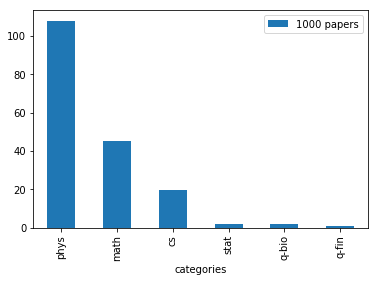

In [65]:
show_cats(all_data)

---

In [79]:
# franction of records with more than one category
sum( len(str(category).split())>1 for category in all_data.categories ) / len(all_data)

0.4091766514130017

In [74]:
sum(mygen)

23427

In [59]:
np.isnan('nan')

TypeError: ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

---

### old

In [7]:
# load the csv's obtained with 'arXiv_metadata_harvester.ipynb'

#dir_ = os.path.join("data", "arXivMeta_completed")
#dir_ = os.path.join("data", "arXivMeta_example_bak")

dfs = {}

# create dict of file-lists dfs = {'cs': [file1, ...], 'math': ..., etc.}
for file in os.listdir(dir_):
    info = re.search(r'arXivMeta_(.+?)_(.+?)\.(\w+?)', file)
    cat = info.group(1)
    date = info.group(2)
    print(f'{cat:>9}: {date}')
    
    file_path = os.path.join(dir_, file)
    
    if cat not in dfs:
        dfs[cat] = [file_path]
    else:
        dfs[cat].append(file_path)

# create dict of data_frames dfs = {'cs': pd.DataFrame(), 'math': ..., etc.}       
def getdf(file_list):
    cat_dfs = [pd.read_csv(file, delimiter='\t') for file in file_list]
    return pd.concat(cat_dfs)

dfs = {cat: getdf(cat_files) for (cat, cat_files) in dfs.items()}

       cs: from_2016-01-01_to_2016-12-31
     math: from_2016-01-01_to_2016-07-01
     math: from_2016-07-02_to_2016-12-31
  physics: from_2016-01-01_to_2016-05-01
  physics: from_2016-05-02_to_2016-09-01
  physics: from_2016-09-02_to_2016-12-31
    q-bio: from_2016-01-01_to_2016-12-31
    q-fin: from_2016-01-01_to_2016-12-31
     stat: from_2016-01-01_to_2016-12-31


---

# Explore and select the data

In [8]:
# now we have for example

dfs['math'][:3]

,id,prim_cat,sec_cats,title,abstract
0,0704.0189,math,math.GR,Monoid generalizations of the Richard Thompson...,"The groups G_{k,1} of Richard Thompson and G..."
1,0704.1313,math,math.GT math.CO,Mutant knots and intersection graphs,We prove that if a finite order knot invaria...
2,0704.2146,math,math.CO,Connected Edge-Disjoint Unions of Tur\'an Graphs,A finite connected graph $G_r^\sigma$ is con...


In [9]:
# check if there are no duplicates (at least by 'id')

[(cat, 0 == len(df.id) - len(df.id.unique())) for (cat,df) in dfs.items()]

[('cs', True),
 ('math', True),
 ('physics', True),
 ('q-bio', True),
 ('q-fin', True),
 ('stat', True)]

In [10]:
# concat all data_frames into one

full_df = pd.concat(dfs.values())

# get a 10% sample to play with

sample_df = full_df.sample(frac=0.1, random_state=123)
sample_df.reset_index(inplace=True)
len(sample_df)

16128

In [11]:
def show_cats(df):
    
    cats = df.prim_cat.unique()
    record_counts = []
    
    for cat in cats:
        count = sum(df.prim_cat == cat)
        record_counts.append( [cat, count/1000] )
    
    record_counts = sorted(record_counts, key = lambda x: x[1], reverse=True)
    
    record_counts = np.array(record_counts)
    record_counts_df = pd.DataFrame({'categories': record_counts[:,0], '1000 papers': record_counts[:,1]}).set_index('categories')
    display(record_counts_df)
    record_counts_df.astype('float').plot.bar()
    plt.show()

,1000 papers
categories,
physics,8.003
math,4.546
cs,2.62
stat,0.565
q-bio,0.295
q-fin,0.099


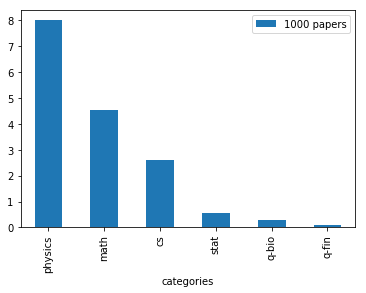

In [12]:
# plot the number of papers in each class
# the dataset is highly unbalanced, there's orders of magnitude between the most and the least frequent class

show_cats(sample_df)

# the world of quantative finance seems to be less keen on spending time writing papers than physicists

In [13]:
# get primary_categories (prim_cat) and text (title+abstract) only
# and safe those in 'bare data_frames'

def strip(df):
    df_2 = pd.concat([(df.title + " " + df.abstract).astype('str'),
                      df.prim_cat.astype('category')], axis=1)
    df_2.columns = ['text', 'label']
    return df_2

bare_dfs = {cat: strip(df) for (cat, df) in dfs.items()}

bare_sample_df = strip(sample_df)

In [14]:
# now we have for example

with pd.option_context('display.max_colwidth', 110):
    display(bare_sample_df[:3])

,text,label
0,The IBM 2016 Speaker Recognition System In this paper we describe the recent advancements made in the IB...,cs
1,The 2(2S+1)- Formalism and Its Connection with Other Descriptions In the framework of the Joos-Weinberg ...,math
2,Regression-based Intra-prediction for Image and Video Coding By utilizing previously known areas in an i...,cs


---

### One could also have a look at the papers' secondary categories of which there are almost 200 and there can be many such categories per paper. Maybe later...

In [15]:
# TODO side-project:
# classify by subcategories (first entries in the list in 'sec_cats' of each paper)

In [16]:
# one-hot-encode the 
ids_with_cats_ugly = full_df[['id', 'sec_cats']].set_index('id').sec_cats.str.split(expand=True).stack()
print(ids_with_cats_ugly[:10])

id_with_cats_df = pd.get_dummies(ids_with_cats_ugly).groupby(level=0).sum()
id_with_cats_df[:3]

id          
0704.0361  0      cs.IT
           1    math.IT
0704.0590  0      cs.IT
           1    math.IT
0704.0671  0      cs.IT
           1      cs.LG
           2    math.IT
0704.0805  0      cs.IT
           1    math.IT
0704.0858  0      cs.CR
dtype: object


,acc-phys,adap-org,alg-geom,ao-sci,astro-ph,astro-ph.CO,astro-ph.EP,astro-ph.GA,astro-ph.HE,astro-ph.IM,...,q-fin.TR,quant-ph,solv-int,stat.AP,stat.CO,stat.ME,stat.ML,stat.OT,stat.TH,supr-con
id,,,,,,,,,,,,,,,,,,,,,
0704.0189,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0704.0334,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0704.0345,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [17]:
len(id_with_cats_df.columns)

168

In [18]:
# TODO take care of adap-org (nlin.AO), chao-dyn(nlin.CD), patt-sol (nlin.PS) etc.:

# Each category should be in the format 'general.specic' (e.g. 'astr-ph.CO') or just 'general' (e.g. 'astro-ph')
# but some of our columns are assigned to 'specific' in the spelled-out format (eg. chao-dyn instead of nlin.CD)
# See https://arxiv.org/ and http://arxitics.com/help/categories

# for column in id_with_cats_df:
#     print(column)

---

### Abstracts of scientific papers tend to be written in a formal style, not contain typos, no direct citations, little references, ...

In [19]:
# take a look at a few abstracts

import random
  
for _ in range(3):
    print(bare_sample_df.text.iloc[random.choice(range(len(bare_sample_df)))])
    print("---")

Chemical Abundance Analysis of Moving Group W11450 (Latham 1)   We present elemental abundances for all seven stars in Moving Group W11450
(Latham 1) to determine if they may be chemically related. These stars appear
to be both spatially and kinematically related, but no spectroscopic abundance
analysis exists in literature. Abundances for eight elements were derived via
equivalent width analyses of high resolution (R $\sim$60,000), high
signal-to-noise ratio ($\langle$SNR$\rangle\sim$100) spectra obtained with the
Otto Struve 2.1m telescope and Sandiford Echelle Spectrograph at McDonald
Observatory. The large star-to-star scatter in metallicity, -0.55 $\leq$ [Fe/H]
$\leq$ 0.06 dex ($\sigma$= 0.25), implies these stars were not produced from
the same chemically homogeneous molecular cloud, and are therefore not part of
a remnant or open cluster as previously proposed. Prior to this analysis, it
was suggested that two stars in the group, W11449 & W11450, are possible wide
binaries. The 

### One messy but informative kind of writing they have are LateX formulas.

In [20]:
bare_sample_df.text[8]

'Functional determinants, index theorems, and exact quantum black hole\r\n  entropy   The exact quantum entropy of BPS black holes can be evaluated using\r\nlocalization in supergravity. An important ingredient in this program, that has\r\nbeen lacking so far, is the one-loop effect arising from the quadratic\r\nfluctuations of the exact deformation (the $Q\\mathcal{V}$ operator). We compute\r\nthe fluctuation determinant for vector multiplets and hyper multiplets around\r\n$Q$-invariant off-shell configurations in four-dimensional $\\mathcal{N}=2$\r\nsupergravity with $AdS_{2} \\times S^{2}$ boundary conditions, using the\r\nAtiyah-Bott fixed-point index theorem and a subsequent zeta function\r\nregularization. Our results extend the large-charge on-shell entropy\r\ncomputations in the literature to a regime of finite charges. Based on our\r\nresults, we present an exact formula for the quantum entropy of BPS black holes\r\nin $\\mathcal{N}=2$ supergravity. We explain cancellations co

### Let's map those into a single 'word'

In [21]:
# mask all LaTeX with a single word ' _LATEX_ '

from sklearn.base import BaseEstimator, TransformerMixin

class DeLaTeX(BaseEstimator, TransformerMixin):
    """
    Replace '\$(.+)?\$' with ' _LATEX_ '
    """

    def __init__(self):
        return None

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X.str.replace(r'\$(.+)?\$', ' _LATEX_ ')

In [22]:
delatex = DeLaTeX()
delatex.transform(bare_sample_df.text)[8]

'Functional determinants, index theorems, and exact quantum black hole\r\n  entropy   The exact quantum entropy of BPS black holes can be evaluated using\r\nlocalization in supergravity. An important ingredient in this program, that has\r\nbeen lacking so far, is the one-loop effect arising from the quadratic\r\nfluctuations of the exact deformation (the  _LATEX_  operator). We compute\r\nthe fluctuation determinant for vector multiplets and hyper multiplets around\r\n _LATEX_ \r\nsupergravity with  _LATEX_  boundary conditions, using the\r\nAtiyah-Bott fixed-point index theorem and a subsequent zeta function\r\nregularization. Our results extend the large-charge on-shell entropy\r\ncomputations in the literature to a regime of finite charges. Based on our\r\nresults, we present an exact formula for the quantum entropy of BPS black holes\r\nin  _LATEX_  supergravity. We explain cancellations concerning\r\n _LATEX_  supergravity that were observed in\r\narXiv:1111.1161. We also make com

---

## Let's build a simple untuned pipeline with a couple shallow classifiers
### We relay on the *class_weight* argument to account for the imbalance of our data

In [23]:
# Choose the data_frame

work_df = bare_sample_df

print(len(work_df))
work_df.dtypes

16128


text       object
label    category
dtype: object

In [24]:
from sklearn.model_selection import train_test_split

text_train, text_test, label_train, label_test = train_test_split(work_df.text, work_df.label, test_size=0.33, random_state=123)

In [25]:
# encode the labels, 'cs' -> 0, ..., 'stat' -> 5

from sklearn import preprocessing

label_e = preprocessing.LabelEncoder()
y_train = label_e.fit_transform(label_train)
y_test = label_e.transform(label_test)

print(list(label_e.classes_))

#label_e.inverse_transform([0]) # array(['cs'], dtype=object)

['cs', 'math', 'physics', 'q-bio', 'q-fin', 'stat']


### Let's first build the pipe and push the data trough step by step.

In [26]:
notex_text_train = delatex.fit_transform(text_train)
notex_text_test = delatex.transform(text_test)

In [30]:
from sklearn.feature_extraction.text import CountVectorizer

count_v = CountVectorizer(strip_accents='unicode')
word_counts_train = count_v.fit_transform(notex_text_train)
word_counts_test = count_v.transform(notex_text_test)
word_counts_train.shape

(10805, 37937)

In [31]:
# Why is there fewer rows? Were they empty?

In [32]:
# take a look at the most frequent words (after using the 'max_df' above)

sum_word_counts_train = word_counts_train.sum(axis=0)
sorted([(sum_word_counts_train[0, i], word) for word, i in count_v.vocabulary_.items()],reverse=True)[:15]

# The '_latex_' word of ours id dangerously high.
# Yet I would still hope that it is underrepresented in quantitative biology or quantitative finance
# We'll settle on max_df=0.8
# 
# Maybe we should have balanced the classes...

[(113420, 'the'),
 (71769, 'of'),
 (39808, 'and'),
 (35847, 'in'),
 (30939, 'to'),
 (23502, 'we'),
 (21230, 'is'),
 (20436, 'for'),
 (15495, 'that'),
 (14938, '_latex_'),
 (14689, 'with'),
 (12535, 'on'),
 (11021, 'this'),
 (10733, 'are'),
 (10459, 'by')]

In [36]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer

def build_arXivMeta_clf(model):
    pipe = []
    pipe.append(( 'delatex', DeLaTeX() ))
    pipe.append(( 'count_v', CountVectorizer(strip_accents='unicode', min_df = 2, max_df = 0.8)  ))
    pipe.append(( 'tfidf_t', TfidfTransformer(use_idf=False)  ))
    pipe.append(( 'sgd_clf', model  ))

    return Pipeline(pipe)

In [37]:
# our first model, an linear SVMM with stochastic gradient descent

from sklearn.linear_model import SGDClassifier

arXivMeta_clf_1 = build_arXivMeta_clf(
    SGDClassifier(loss='hinge', class_weight="balanced", n_jobs=-1, max_iter=1000, tol=1e-3)
)
arXivMeta_clf_1.fit(text_train, y_train)

Pipeline(memory=None,
     steps=[('delatex', DeLaTeX()), ('count_v', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.8, max_features=None, min_df=2,
        ngram_range=(1, 1), preprocessor=None, sto..._state=None, shuffle=True, tol=0.001,
       validation_fraction=0.1, verbose=0, warm_start=False))])

### Ok, let's just have some fun first:

In [38]:
random_abstracts = pd.Series(["""
The Lack of A Priori Distinctions Between Learning Algorithms  This is the first of
two papers that use off-training set (OTS) error to investigate the assumption-free
relationship between learning algorithms. This first paper discusses the senses in
which there are no a priori distinctions between learning algorithms. (The second
paper discusses the senses in which there are such distinctions.) In this first paper
it is shown, loosely speaking, that for any two algorithms A and B, there are "as many"
targets (or priors over targets) for which A has lower expected OTS error than B as
vice versa, for loss functions like zero-one loss. In particular, this is true if A
is cross-validation and B is "anti-cross-validation'' (choose the learning algorithm
with largest cross-validation error). This paper ends with a discussion of the
implications of these results for computational learning theory. It is shown that one
cannot say: if empirical misclassification rate is low, the Vapnik-Chervonenkis
dimension of your generalizer is small, and the training set is large, then with high
probability your OTS error is small. Other implications for "membership queries"
algorithms and "punting" algorithms are also discussed.
""",
"""
X-rays quarks lepton scattering experiment field
""",
"""
genes DNA RNA sequencing protein species fenotype 
""",
"""
computer algorithm graph sorting depth first interface
""",
"""
We offer a novel less intuitive proof of $\limit_{x\to 0} x = 0$,
""",
"""
infllation resources market stock bonds derivatives
""",
"""
distribution Bayesian p value marginalization Monte Carlo
"""
])


label_e.inverse_transform(arXivMeta_clf_1.predict(random_abstracts))

array(['cs', 'physics', 'q-bio', 'cs', 'math', 'q-fin', 'stat'], dtype=object)

In [39]:
# looks promising

### Check the multilabel classification accuracy

In [40]:
from sklearn import metrics

def show_metrics(clf):
    predicted_y_test = clf.predict(text_test)
    print(metrics.classification_report(y_test, predicted_y_test, target_names=label_e.classes_))
    print(metrics.confusion_matrix(y_test, predicted_y_test))

In [41]:
show_metrics(arXivMeta_clf_1)

              precision    recall  f1-score   support

          cs       0.69      0.71      0.70       894
        math       0.80      0.74      0.77      1510
     physics       0.93      0.90      0.91      2633
       q-bio       0.42      0.55      0.48        80
       q-fin       0.31      0.57      0.40        30
        stat       0.33      0.59      0.42       176

   micro avg       0.80      0.80      0.80      5323
   macro avg       0.58      0.67      0.61      5323
weighted avg       0.82      0.80      0.81      5323

[[ 633  107   37   12    8   97]
 [ 179 1115  121   10   16   69]
 [  66  143 2362   29    7   26]
 [  10    4   11   44    1   10]
 [   1    6    1    0   17    5]
 [  30   26    3    9    5  103]]


In [42]:
# TODO: understand what the above values are

In [43]:
# try a random forest

from sklearn.ensemble import RandomForestClassifier

arXivMeta_clf_2 = build_arXivMeta_clf(
    RandomForestClassifier(class_weight = 'balanced', n_estimators=100, max_depth=10, criterion='entropy', random_state=123)
)
arXivMeta_clf_2.fit(text_train, y_train)

Pipeline(memory=None,
     steps=[('delatex', DeLaTeX()), ('count_v', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.8, max_features=None, min_df=2,
        ngram_range=(1, 1), preprocessor=None, sto...tors=100, n_jobs=None, oob_score=False,
            random_state=123, verbose=0, warm_start=False))])

In [44]:
show_metrics(arXivMeta_clf_2)

              precision    recall  f1-score   support

          cs       0.61      0.59      0.60       894
        math       0.67      0.74      0.70      1510
     physics       0.89      0.81      0.85      2633
       q-bio       0.31      0.41      0.35        80
       q-fin       0.62      0.43      0.51        30
        stat       0.33      0.48      0.40       176

   micro avg       0.74      0.74      0.74      5323
   macro avg       0.57      0.58      0.57      5323
weighted avg       0.75      0.74      0.74      5323

[[ 530  198   64   15    3   84]
 [ 176 1119  156    7    5   47]
 [  96  318 2145   45    0   29]
 [  15    3   22   33    0    7]
 [   4    9    2    0   13    2]
 [  46   30    8    7    0   85]]


In [ ]:
# TODO:

# add LogisticRegression, RidgeClassifier with the 'class_weight=balanced' argument

# make a prettier confusion matrix with a heat_map 

# grid search with cross validation

# try Hash Vectorizer instead of CountVectorizer
# balance the classes by up-/down-sampling and use other models (MultiNomial Naive Bayes)
# out-of-core learning ?

# see how accuracy scales with data volume (we have 800 MB to go around)

# unsupervised learning:
# LDA
# clustering
# visualization: t-SNE ?

# deep learning ?

# multilabel learning (with the secondary classes) ?